In [1]:
# Let's import the needed packages

# To deal with arrays 
import xarray as xr
import pandas as pd 
pd.options.mode.chained_assignment = None
import numpy as np

# To plot curves
import matplotlib.pyplot as plt

# To plot the map
import cartopy.crs as ccrs

# Importing Models
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

# Prediction Scores
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Dimensionality reduction 
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

#import our useful functions 
import useful_functions

# One-month prediction of El Nino Events

In [2]:
# Get the data for a 1-month prediction, split and scale the data
X, y = useful_functions.get_data("data/preprocessed_data/nino_dataset_1m.npz")
X_train, X_test, y_train, y_test= useful_functions.split_scale_data(X, y, RANDOM_SPLIT = False, train_size = 374)

==== GET THE DATA ====
Shape of X: (474, 64800)
Shape of y: (474,)
First 25 elements of y: [0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
==== SPLIT & SCALE THE DATA ====
Shape of X_train: (374, 64800)
Shape of y_train: (374,)
Shape of X_test: (100, 64800)
Shape of y_test: (100,)


The problem here is that we have a small amount of data and the data are in high dimension. 
**=> High risk of overfitting**

Let us try to first simple model so we can have a baseline.

## 1. Baseline n°1 - LDA

In this part, we explore a simple model, to have a first prediction score and then decide guideines for the rest of our work.

### 1.1 First evaluation

In [3]:
# Define the classifier
lda = LinearDiscriminantAnalysis()

# Fit the model on the data
lda.fit(X_train,y_train)

# Get the prediction
y_test_pred_lda = lda.predict(X_test)
y_train_pred_lda = lda.predict(X_train)

# Computation of the AUC and accuracy
roc_auc_score_lda_train = roc_auc_score(y_train, lda.predict_proba(X_train)[:, 1])
accuracy_score_lda_train = accuracy_score(y_train, y_train_pred_lda)

roc_auc_score_lda_test = roc_auc_score(y_test, lda.predict_proba(X_test)[:, 1])
accuracy_score_lda_test = accuracy_score(y_test, y_test_pred_lda)

# Print the results
print("==== TRAIN ====")
print(f"Accuracy for TRAIN data: {accuracy_score_lda_train:.3f}")
print(f"     AUC for TRAIN data: {roc_auc_score_lda_train:.3f}")

print("==== TEST ====")
print(f"Accuracy for TEST data: {accuracy_score_lda_test:.3f}")
print(f"     AUC for TEST data: {roc_auc_score_lda_test:.3f}")


==== TRAIN ====
Accuracy for TRAIN data: 0.984
     AUC for TRAIN data: 0.998
==== TEST ====
Accuracy for TEST data: 0.860
     AUC for TEST data: 0.947


Overfitting !!!
Before trying this model, we will try to reduce the overfitting by performing dimensionality reduction.

### 1.2 Dimensionality reduction: PCA

Text(0.5, 1.0, 'Cumulative Explained Variance by Principal Components')

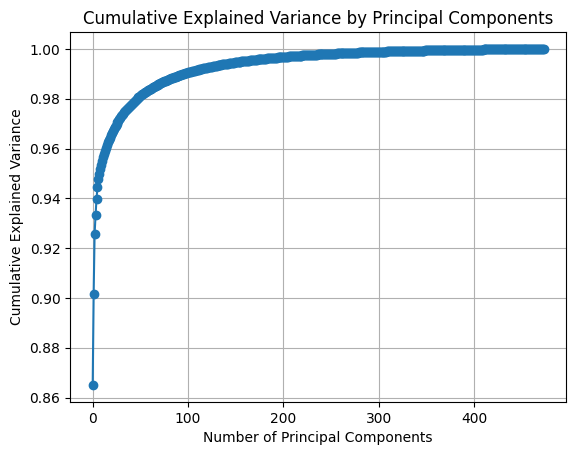

In [4]:
# PCA
PCA_sst = PCA(n_components = None)
PCA_sst.fit(X)

# Computation of the explained variance ratio
explained_variance_ratio_sst = PCA_sst.explained_variance_ratio_

# Plot of the explained variance ratio
plt.grid()
plt.plot(np.cumsum(explained_variance_ratio_sst), marker = 'o')

plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by Principal Components')

In [5]:
# Perform several LDA with different value of p to get a validation curve for this parameter
p_values = np.linspace(1, 100, 100).astype(int)
p_values = p_values.astype(int)
test_score_accuracy = []
train_score_accuracy = []

for p in p_values:
    # PCA with p principal components
    PCA_sst = PCA(n_components=p)
    PCA_sst.fit(X)

    # Project data
    Xp_sst = PCA_sst.transform(X)
    X_train, X_test, y_train, y_test = useful_functions.split_scale_data(Xp_sst, y, RANDOM_SPLIT = False, train_size = 374, verbose = False)

    # Define the classifier
    lda = LinearDiscriminantAnalysis()

    # Fit the model on the data
    lda.fit(X_train,y_train)

    # Get the prediction
    y_test_pred_lda = lda.predict(X_test)
    y_train_pred_lda = lda.predict(X_train)

    # Computation of the accuracy
    test_score_accuracy.append(accuracy_score(y_test, y_test_pred_lda))
    train_score_accuracy.append(accuracy_score(y_train, y_train_pred_lda))


In [6]:
# Get the best score
best_index = np.argsort(-np.array(test_score_accuracy))[0]
best_p_value = p_values[best_index]
best_test_score_pca = test_score_accuracy[best_index]
best_train_score_pca = train_score_accuracy[best_index]

# Prints
print(f"Best value of p - PCA : {best_p_value}")
print(f"Train Score for the best p: {best_train_score_pca}")
print(f"Test Score for the best p: {best_test_score_pca}")
print(f"Amélioration tu score de test: + {best_test_score_pca - accuracy_score_lda_test:.2f}")

Best value of p - PCA : 44
Train Score for the best p: 0.93048128342246
Test Score for the best p: 0.93
Amélioration tu score de test: + 0.07


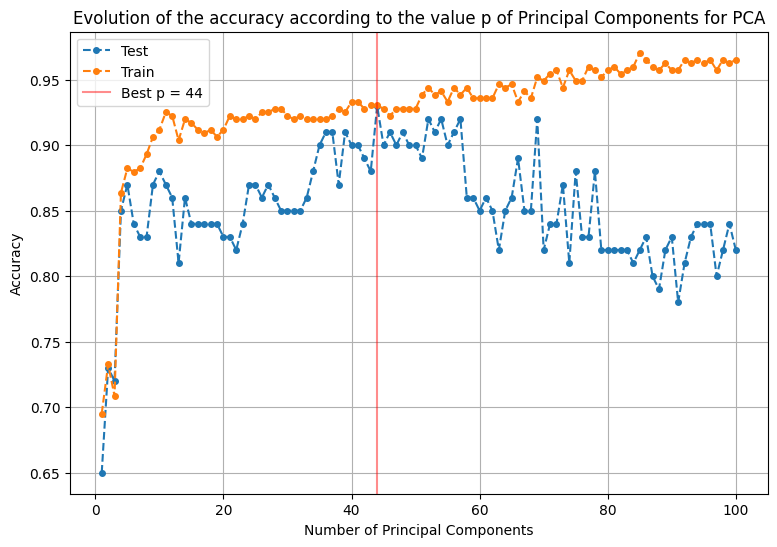

In [7]:
# Plot the validation curve
plt.figure(figsize=(9,6))
plt.plot(p_values, test_score_accuracy, 'o', markersize=4, ls='--', label="Test")
plt.plot(p_values, train_score_accuracy, 'o', markersize=4, ls='--', label="Train")
plt.axvline(x = best_p_value, color = 'red', linestyle = '-', label = f'Best p = {best_p_value}', alpha = 0.45)
plt.title("Evolution of the accuracy according to the value p of Principal Components for PCA")
plt.xlabel("Number of Principal Components")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()

Train accuracy with the best p: 0.93
Train AUC with the best p: 0.98
Test accuracy with the best p: 0.90
Test auc with the best p: 0.96


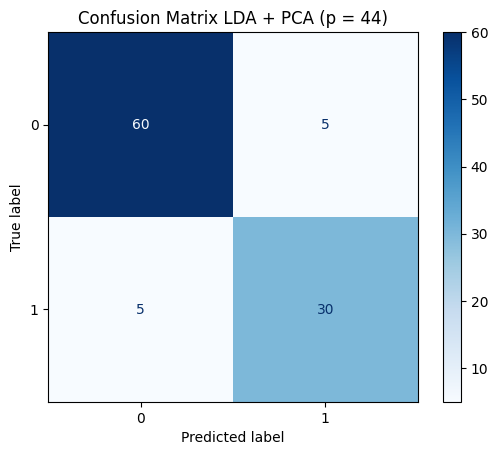

In [8]:
# PCA with the best value of p
PCA_sst = PCA(n_components = best_p_value)
PCA_sst.fit(X)

Xp_sst = PCA_sst.transform(X)
X_train, X_test, y_train, y_test = useful_functions.split_scale_data(
    Xp_sst, y, RANDOM_SPLIT = False, train_size = 374, verbose = False
)

# Make predictions 
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
y_test_pred_lda = lda.predict(X_test)
y_train_pred_lda = lda.predict(X_train)

# Compute the scores 
train_accuracy = accuracy_score(y_train, y_train_pred_lda)
roc_auc_score_lda_train = roc_auc_score(y_train, lda.predict_proba(X_train)[:, 1])
print(f"Train accuracy with the best p: {train_accuracy:.2f}")
print(f"Train AUC with the best p: {roc_auc_score_lda_train:.2f}")

test_accuracy = accuracy_score(y_test, y_test_pred_lda)
roc_auc_score_lda_test = roc_auc_score(y_test, lda.predict_proba(X_test)[:, 1])
print(f"Test accuracy with the best p: {test_accuracy:.2f}")
print(f"Test auc with the best p: {roc_auc_score_lda_test:.2f}")

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred_lda)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=lda.classes_)
disp.plot(cmap='Blues')
plt.title(f"Confusion Matrix LDA + PCA (p = {best_p_value})")
plt.show()

## 2. Linear Regression, Ridge and Lasso

In this part, we explore the use of Ridge and Lasso Regressions for the classification task, as we want to perform regularization to prevent overfitting.

### 2.1 Ridge Classification 

In [9]:
# We work with the orinial data and split it 
X_train, X_test, y_train, y_test = useful_functions.split_scale_data(
    X, y, RANDOM_SPLIT=False, train_size=374
)

X_train_cv, X_validation, y_train_cv, y_validation = useful_functions.split_scale_data(
    X_train, y_train, RANDOM_SPLIT=False, train_size=300
)

==== SPLIT & SCALE THE DATA ====
Shape of X_train: (374, 64800)
Shape of y_train: (374,)
Shape of X_test: (100, 64800)
Shape of y_test: (100,)
==== SPLIT & SCALE THE DATA ====
Shape of X_train: (300, 64800)
Shape of y_train: (300,)
Shape of X_test: (74, 64800)
Shape of y_test: (74,)


In [10]:
# Define and evaluate the Ridge classifier on the original training and test data
ridge = RidgeClassifier(alpha=1.0)  # Default hyperparameter
ridge.fit(X_train, y_train)

print("==== TRAIN ====")
print(f"Accuracy for TRAIN data: {ridge.score(X_train, y_train):.3f}")
print("==== TEST ====")
print(f"Accuracy for TEST data: {ridge.score(X_test, y_test):.3f}")


==== TRAIN ====
Accuracy for TRAIN data: 1.000
==== TEST ====
Accuracy for TEST data: 0.850


c:\ENPC\anaconda3\envs\climate\Lib\site-packages\sklearn\linear_model\_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=4.73634e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


In [11]:
# Hyperparameter tuning: Evaluate different lambda (regularization strength) values
lambda_values = np.logspace(1, 7, 100)

accuracy_train_cv_list = []
accuracy_valid_list = []
coefficients = []

for lambda_val in lambda_values:
    ridge = RidgeClassifier(alpha=lambda_val)
    ridge.fit(X_train_cv, y_train_cv)

    # Store accuracies for training and validation data
    accuracy_train_cv_list.append(ridge.score(X_train_cv, y_train_cv))
    accuracy_valid_list.append(ridge.score(X_validation, y_validation))

    # Store coefficients
    coefficients.append(ridge.coef_)

coefficients = np.array(coefficients)

# Find the lambda value that maximizes validation accuracy
max_accuracy_index = np.argmax(accuracy_valid_list)
max_lambda = lambda_values[max_accuracy_index]
max_accuracy = accuracy_valid_list[max_accuracy_index]
best_train_cv_accuracy = accuracy_train_cv_list[max_accuracy_index]

print(f"Best lambda value after validation: {max_lambda:.1f}")
print(f"Accuracy for training: {best_train_cv_accuracy:.3f}")
print(f"Accuracy for validation: {max_accuracy:.3f}")


Best lambda value after validation: 16297.5
Accuracy for training: 0.983
Accuracy for validation: 0.932


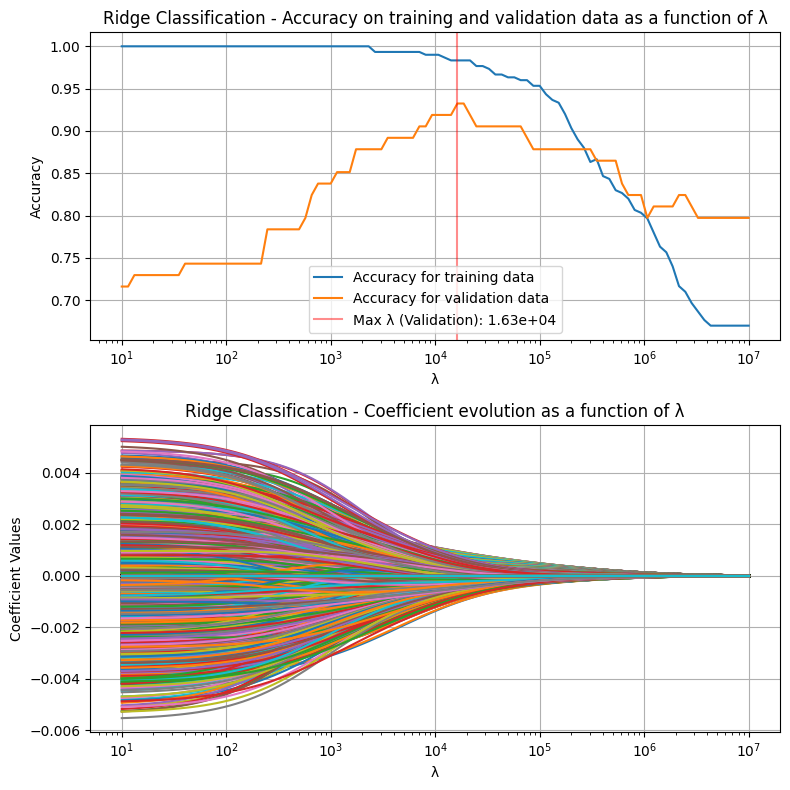

In [12]:
# Plot accuracy and coefficient evolution as a function of lambda
plt.figure(figsize=[8, 8])

# Plot accuracy for training and validation sets
plt.subplot(2, 1, 1)
plt.semilogx(lambda_values, accuracy_train_cv_list, label="Accuracy for training data")
plt.semilogx(lambda_values, accuracy_valid_list, label="Accuracy for validation data")
plt.axvline(x=max_lambda, color='r', linestyle='-', label=f'Max λ (Validation): {max_lambda:.2e}', alpha=0.45)
plt.legend()
plt.xlabel('λ')
plt.ylabel('Accuracy')
plt.title('Ridge Classification - Accuracy on training and validation data as a function of λ')
plt.grid()

# Plot coefficient evolution
plt.subplot(2, 1, 2)
plt.semilogx(lambda_values, coefficients[:, 0])
plt.xlabel('λ')
plt.ylabel('Coefficient Values')
plt.grid()
plt.title('Ridge Classification - Coefficient evolution as a function of λ')

plt.tight_layout()
plt.show()

Train accuracy with the best λ: 0.98
Train AUC with the best λ: 1.00
Test accuracy with the best λ: 0.91
Test AUC with the best λ: 0.96


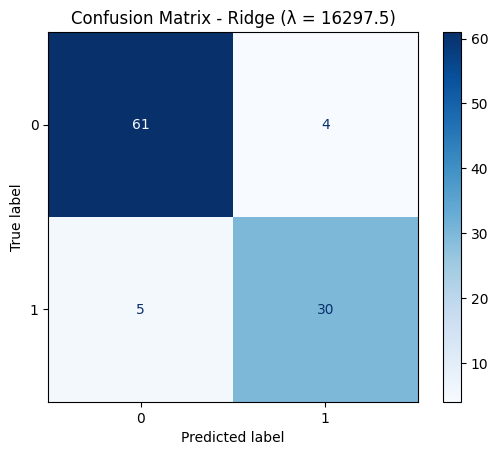

In [13]:
# Evaluate the best Ridge model
ridge = RidgeClassifier(alpha=max_lambda)
ridge.fit(X_train, y_train)

y_train_pred_ridge = ridge.predict(X_train)
y_test_pred_ridge = ridge.predict(X_test)

# Decision values for AUC computation
train_decision_values = ridge.decision_function(X_train)
test_decision_values = ridge.decision_function(X_test)

# Compute scores
train_accuracy = accuracy_score(y_train, y_train_pred_ridge)
roc_auc_score_train = roc_auc_score(y_train, train_decision_values)
print(f"Train accuracy with the best λ: {train_accuracy:.2f}")
print(f"Train AUC with the best λ: {roc_auc_score_train:.2f}")

test_accuracy = accuracy_score(y_test, y_test_pred_ridge)
roc_auc_score_test = roc_auc_score(y_test, test_decision_values)
print(f"Test accuracy with the best λ: {test_accuracy:.2f}")
print(f"Test AUC with the best λ: {roc_auc_score_test:.2f}")

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred_ridge)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=ridge.classes_)
disp.plot(cmap='Blues')
plt.title(f"Confusion Matrix - Ridge (λ = {max_lambda:.1f})")
plt.show()

### 2.2 Lasso Classification

In this part, we will use the Lasso algorithm to perform a regularization of our model, trying to prevent overfitting. As there is no "LassoClassifier" function, we will use the LogisticRegression function with penalty parameter set to "l1".

In [14]:
# Define the classifier
lasso = LogisticRegression(penalty = 'l1', solver = 'liblinear', C = 1.0) 
lasso.fit(X_train, y_train)

# Print the results
print("==== TRAIN ====")
print(f"Accuracy for TRAIN data: {lasso.score(X_train, y_train):.3f}")
print("==== TEST ====")
print(f"Accuracy for TEST data: {lasso.score(X_test, y_test):.3f}")

==== TRAIN ====
Accuracy for TRAIN data: 1.000
==== TEST ====
Accuracy for TEST data: 0.880


In [15]:
# Prepare the regularization parameter values
C_values = np.logspace(-3, 2, 50)

# Initialisation of the lists that will contain the accuracies and the coefficients
accuracy_train_cv_list = []
accuracy_valid_list = []
coefficients = []

for i in range(len(C_values)):
    # Define the classifier
    lasso = LogisticRegression(penalty = 'l1', solver = 'liblinear', C = C_values[i])
    lasso.fit(X_train_cv, y_train_cv)

    # Predict
    y_train_cv_pred = lasso.predict(X_train_cv)
    y_valid_pred = lasso.predict(X_validation)
    
    # Computation of the accuracy for train and validation
    accuracy_train_cv_lasso = lasso.score(X_train_cv, y_train_cv)
    accuracy_valid_lasso = lasso.score(X_validation, y_validation)

    # Add the values to the accuracy lists
    accuracy_train_cv_list.append(accuracy_train_cv_lasso)
    accuracy_valid_list.append(accuracy_valid_lasso)
    
    # Store the coefficients
    coefficients.append(lasso.coef_)
    
coefficients = np.array(coefficients)

# Find the C parameter that maximises the validation accuracy
max_accuracy_index = np.argmax(accuracy_valid_list)
max_C = C_values[max_accuracy_index]
max_accuracy = accuracy_valid_list[max_accuracy_index]
best_train_cv_accuracy = accuracy_train_cv_list[max_accuracy_index]

print(f"Best lambda value after validation: {max_C:.1f}")
print(f"Accuracy for training: {best_train_cv_accuracy:.3f}")
print(f"Accuracy for validation: {max_accuracy:.3f}")

Best lambda value after validation: 0.1
Accuracy for training: 0.937
Accuracy for validation: 0.946


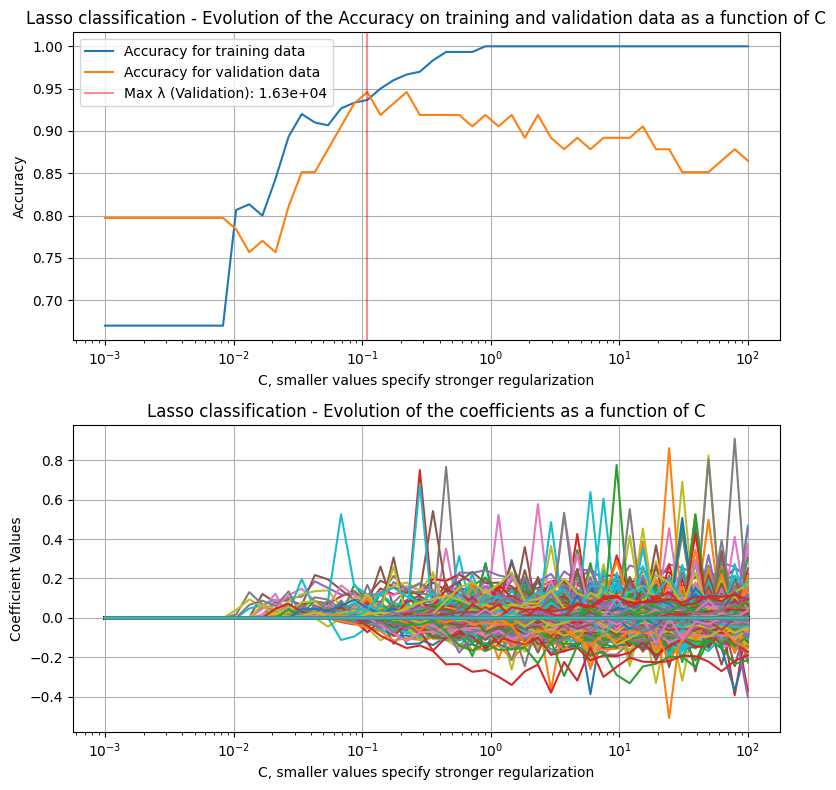

In [16]:
# Plot the results
plt.figure(figsize = [8,8])
plt.subplot(2,1,1)

plt.semilogx(C_values, accuracy_train_cv_list, label="Accuracy for training data")
plt.semilogx(C_values, accuracy_valid_list, label="Accuracy for validation data")
plt.axvline(x = max_C, color='r', linestyle='-', label=f'Max λ (Validation): {max_lambda:.2e}', alpha = 0.45)
plt.legend()
plt.xlabel('C, smaller values specify stronger regularization')
plt.ylabel('Accuracy')
plt.title('Lasso classification - Evolution of the Accuracy on training and validation data as a function of C')
plt.grid()

plt.subplot(2,1,2)
plt.semilogx(C_values, coefficients[:, 0])
plt.xlabel('C, smaller values specify stronger regularization')
plt.ylabel('Coefficient Values')
plt.grid()
plt.title('Lasso classification - Evolution of the coefficients as a function of C')

plt.tight_layout() 

Train accuracy with the best λ: 0.94
Train AUC with the best λ: 0.98
Test accuracy with the best λ: 0.88
Test auc with the best λ: 0.97


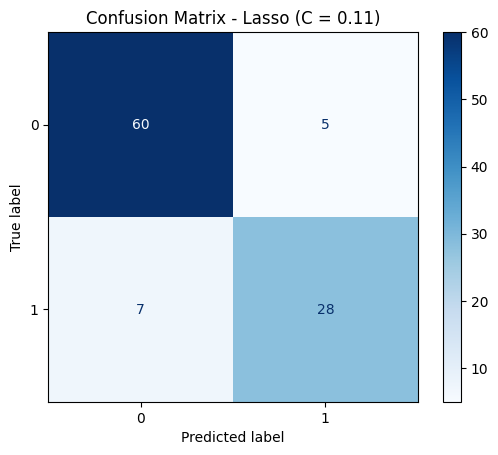

In [17]:
# Evaluate the best Lasso model
lasso = LogisticRegression(penalty='l1', solver='liblinear', C = max_C)
lasso.fit(X_train, y_train)

y_test_pred_lasso = lasso.predict(X_test)
y_train_pred_lasso = lasso.predict(X_train)

train_decision_values = lasso.decision_function(X_train)
test_decision_values = lasso.decision_function(X_test)

# Compute the scores 
train_accuracy = accuracy_score(y_train, y_train_pred_lasso)
roc_auc_score_train = roc_auc_score(y_train, train_decision_values)
print(f"Train accuracy with the best λ: {train_accuracy:.2f}")
print(f"Train AUC with the best λ: {roc_auc_score_train:.2f}")

test_accuracy = accuracy_score(y_test, y_test_pred_lasso)
roc_auc_score_test = roc_auc_score(y_test, test_decision_values)
print(f"Test accuracy with the best λ: {test_accuracy:.2f}")
print(f"Test auc with the best λ: {roc_auc_score_test:.2f}")

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, lasso.predict(X_test))

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=lasso.classes_)
disp.plot(cmap='Blues')
plt.title(f"Confusion Matrix - Lasso (C = {max_C:.2f})")
plt.show()

## 3. Test Different Models

In [18]:
# We work with the orinial data and split it 
X, y = useful_functions.get_data("data/preprocessed_data/nino_dataset_1m.npz")
X_train, X_test, y_train, y_test = useful_functions.split_scale_data(X, y, RANDOM_SPLIT=False, train_size=374)
# Marche mal car il y a trop de données collinéaires: travailler sur les données colllinéaires 

# The models that we are going to use 
models_names = ["QDA", "RandomForestClassifier", "SVC", "GradientBoostingClassifier"]
models = [QuadraticDiscriminantAnalysis(), RandomForestClassifier(), SVC(probability = True), GradientBoostingClassifier()]

# The params of each model for cross validation
qda_params = {'reg_param': [0, 0.1, 0.2, 0.5, 0.7, 0.9]}
rf_params = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]}
svc_params = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
gb_params = {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7]}
param_grids = [ qda_params,rf_params, svc_params, gb_params]

#initialisations of the scores list and names (for the legend of the plot)
model_names_legend = []
auc_scores = []
accuracy_scores = []
best_model_name = None
best_model = None
best_accuracy = 0
best_auc = 0

for i in range (len(models)) :
    #first evaluate the basic model
    model, accuracy, auc = useful_functions.evaluate_model(models[i], models_names[i],  X_train, y_train, X_test, y_test)
    print('\n---------------------')
    model_names_legend.append(models_names[i])
    auc_scores.append(auc)
    accuracy_scores.append(accuracy)

    if accuracy > best_accuracy or (accuracy == best_accuracy and auc > best_auc):
        best_model_name = models_names[i]
        best_model = model  
        best_accuracy = accuracy
        best_auc = auc

    #then tune the model 
    best_estimator_cv, best_params_cv, best_accuracy_cv, best_auc_cv = useful_functions.cross_validation(models[i], param_grids[i], X_train, y_train, X_test, y_test, models_names[i] + " tuned")
    print('\n---------------------')
    model_names_legend.append(models_names[i] + " tuned")
    auc_scores.append(best_auc_cv)
    accuracy_scores.append(best_accuracy_cv)

    if best_accuracy_cv > best_accuracy or (best_accuracy_cv == best_accuracy and best_auc_cv > best_auc):
        best_model_name = models_names[i] + " tuned"
        best_model = best_estimator_cv 
        best_accuracy = best_accuracy_cv
        best_auc = best_auc_cv

print(f"\nBest Model: {best_model_name}")
print(f"Best Accuracy: {best_accuracy:.4f}")
print(f"Best AUC: {best_auc:.4f}")

#now me plot the histograms 
useful_functions.plot_score(model_names_legend, auc_scores, accuracy_scores)

==== GET THE DATA ====
Shape of X: (474, 64800)
Shape of y: (474,)
First 25 elements of y: [0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
==== SPLIT & SCALE THE DATA ====
Shape of X_train: (374, 64800)
Shape of y_train: (374,)
Shape of X_test: (100, 64800)
Shape of y_test: (100,)


c:\ENPC\anaconda3\envs\climate\Lib\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


QDA - Accuracy: 0.48, AUC: 0.5076923076923077

---------------------


c:\ENPC\anaconda3\envs\climate\Lib\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\ENPC\anaconda3\envs\climate\Lib\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\ENPC\anaconda3\envs\climate\Lib\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\ENPC\anaconda3\envs\climate\Lib\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\ENPC\anaconda3\envs\climate\Lib\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\ENPC\anaconda3\envs\climate\Lib\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear"

KeyboardInterrupt: 

If we consider accuracy as the reference score, SVC seems to be the best model. Let's perform PCA on it. 

#### Perform PCA on the best estimator

In [ ]:
# Combine the best model with different values of
p_values = np.linspace(1, 100, 100).astype(int)
p_values = p_values.astype(int)
test_score_accuracy = []
train_score_accuracy = []
models_pca = []

for p in p_values:
    # PCA with p principal components
    PCA_sst = PCA(n_components=p)
    PCA_sst.fit(X)

    # Project data
    Xp_sst = PCA_sst.transform(X)
    X_train, X_test, y_train, y_test = useful_functions.split_scale_data(Xp_sst, y, RANDOM_SPLIT = False, train_size = 374, verbose = False)

    # Define the classifier
    model = best_model

    # Fit the model on the data
    model.fit(X_train,y_train)

    # Get the prediction
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)

    # Computation of the accuracy
    test_score_accuracy.append(accuracy_score(y_test, y_test_pred))
    train_score_accuracy.append(accuracy_score(y_train, y_train_pred))
    models_pca.append(model)

In [ ]:
# Get the best score
best_index = np.argsort(-np.array(test_score_accuracy))[0]
best_p_value = p_values[best_index]
best_test_score_pca = test_score_accuracy[best_index]
best_train_score_pca = train_score_accuracy[best_index]
best_model_pca = models_pca[best_index]

# Prints
print(f"Best value of p - PCA : {best_p_value}")
print(f"Train Score for the best p: {best_train_score_pca}")
print(f"Test Score for the best p: {best_test_score_pca}")
print(f"Amélioration tu score de test: + {best_test_score_pca - accuracy_score_lda_test:.2f}")

Best value of p - PCA : 13
Train Score for the best p: 1.0
Test Score for the best p: 0.93
Amélioration tu score de test: + 0.07


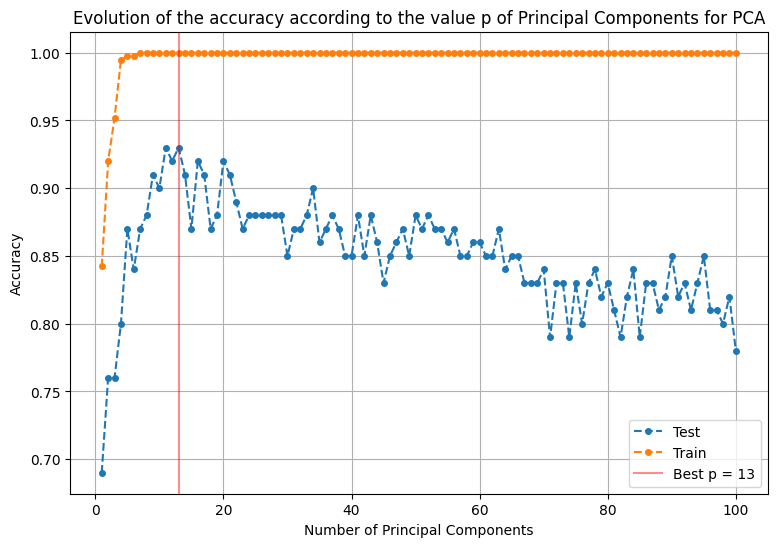

In [ ]:
# Plot the validation curve
plt.figure(figsize=(9,6))
plt.plot(p_values, test_score_accuracy, 'o', markersize=4, ls='--', label="Test")
plt.plot(p_values, train_score_accuracy, 'o', markersize=4, ls='--', label="Train")
plt.axvline(x = best_p_value, color = 'red', linestyle = '-', label = f'Best p = {best_p_value}', alpha = 0.45)
plt.title("Evolution of the accuracy according to the value p of Principal Components for PCA")
plt.xlabel("Number of Principal Components")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()

Test accuracy with the best p: 0.92
Test auc with the best p: 0.97


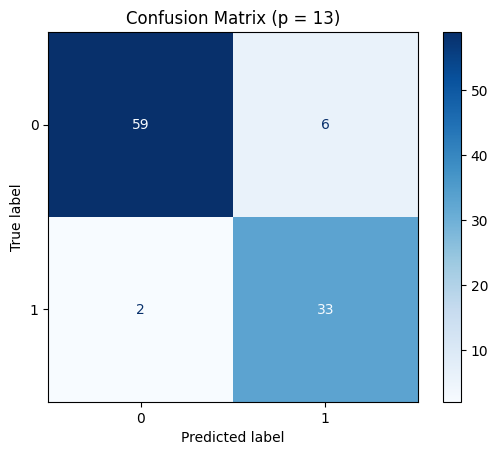

In [ ]:
# PCA with the best value of p
PCA_sst = PCA(n_components = best_p_value)
PCA_sst.fit(X)

Xp_sst = PCA_sst.transform(X)
X_train, X_test, y_train, y_test = useful_functions.split_scale_data(
    Xp_sst, y, RANDOM_SPLIT = False, train_size = 374, verbose = False
)
best_model_pca.fit(X_train, y_train)

# Make predictions 
y_test_pred = best_model_pca.predict(X_test)

# Print the scores
test_accuracy = accuracy_score(y_test, y_test_pred)
roc_auc_score_test = roc_auc_score(y_test, best_model_pca.predict_proba(X_test)[:, 1])
print(f"Test accuracy with the best p: {test_accuracy:.2f}")
print(f"Test auc with the best p: {roc_auc_score_test:.2f}")

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=lda.classes_)
disp.plot(cmap='Blues')
plt.title(f"Confusion Matrix (p = {best_p_value})")
plt.show()

## 4) Neural Networks 

Essayons d'utiliser des neural networks

In [ ]:
param_grid = {
    'hidden_layer_sizes': [
        (128,),              # 1 couche avec 128 neurones
        (128, 64),           # 2 couches : 128 -> 64
        (128, 64, 32),       # 3 couches : 128 -> 64 -> 32
        (256, 128, 64),      # 3 couches plus larges : 256 -> 128 -> 64
    ],
    'alpha': [1e-4, 1e-3, 1e-2],  # Régularisation L2
    'solver': ['adam'],           # Méthode d'optimisation
    'max_iter': [200],            # Nombre d'itérations fixes
}

mlp = MLPClassifier(random_state=42, early_stopping=True, validation_fraction=0.2)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(
    estimator=mlp,
    param_grid=param_grid,
    scoring='accuracy',  # Optimisation de l'accuracy
    cv=cv,
    verbose=1,           # Affiche les étapes de la recherche
    n_jobs=-1            # Utilise tous les cœurs disponibles
)


grid_search.fit(X_train, y_train)

print("Best parameters found:", grid_search.best_params_)
print(f"Best cross-validated accuracy: {grid_search.best_score_:.3f}")


In [ ]:
best_mlp = grid_search.best_estimator_

best_mlp.fit(X_train, y_train)
test_accuracy = best_mlp.score(X_test, y_test)
print(f"Test Accuracy with best parameters: {test_accuracy:.3f}")

y_test_pred = best_mlp.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - Best MLP')
plt.show()
